<a href="https://colab.research.google.com/github/p09323028/2021s_NTU_Big-Data-Marketing/blob/main/Homework/07_%E7%89%A9%E4%BB%A5%E9%A1%9E%E8%81%9A%E4%BA%BA%E4%BB%A5%E5%88%86%E7%BE%A4%E9%A1%A7%E5%AE%A2%E7%9A%84%E5%88%86%E7%BE%A4%E8%88%87%E8%A4%87%E8%A3%BD_%E4%BD%9C%E6%A5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Jinze Wu

Student Number: p09323028

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Download data**
Download data from google cloud

In [ ]:
!gdown --id '1sQxXcpgeHbsoUoktBpetFWNZHcttvGxy' --output customers.xlsx

Downloading...
From: https://drive.google.com/uc?id=1sQxXcpgeHbsoUoktBpetFWNZHcttvGxy
To: /content/customers.xlsx
100% 66.1k/66.1k [00:00<00:00, 51.5MB/s]


# **Customers DataFrame**

In [ ]:
customers = pd.read_excel('customers.xlsx')

In [ ]:
def get_constellation(month, date):
    dates = (21, 20, 21, 21, 22, 22, 23, 24, 24, 24, 23, 22)
    constellations = ('摩羯座', '水瓶座', '雙魚座', '牡羊座', '金牛座', '雙子座', '巨蟹座', '獅子座', '處女座', '天秤座', '天蝎座', '射手座', '魔羯座')
    if date < dates[month-1]:
        return constellations[month-1]
    else:
        return constellations[month]
def constellation_type(z):
    if z in ['牡羊座', '獅子座', '射手座']:
        return '火象'
    if z in ['金牛座', '處女座', '魔羯座']:
        return '土象'
    if z in ['水瓶座', '雙子座', '天秤座']:
        return '風象'
    else:
        return '水象'

In [ ]:
customers['birthdate'] = pd.to_datetime(customers['生日'])
customers['zodiac'] = customers['birthdate'].apply(lambda x: get_constellation(x.month, x.day))
customers['zodiac_type'] = customers['zodiac'].apply(lambda x: constellation_type(x))
customers.head(1)

,客戶ID,年齡,生日,居住地,教育程度,性別,婚姻狀況,職業,辦第一張信用卡的時間,R,F,M_mean,BS_Score,M_sum,CAI,CRI,Basket1,Basket2,Basket3,Basket4,Basket5,首次辦卡年齡,年齡層,首辦年齡層,持卡年數,持卡數,曾分期付款,曾國外消費,02_學費/教育,03_保險,05_捐贈,06_公用事業,07_百貨,08_精品,09_餐飲,10_藥妝,11_3C居家電信,12_量販超市,13_交通(含加值),14_旅遊,15_休閒文化,16_無店舖,X2.中信錢加值,月初,月中,月底,週一,週二,週三,週四,週五,週六,週日,最常消費產業,最常消費月時點,最常消費週時點,birthdate,zodiac,zodiac_type
0,89,59,1953-09-21,大台北地區,學士,1:男,已婚,白領主管,2003-11-27,19,85,1772.717647,369.909059,150681,-0.125625,0.364911,0.17653,-0.81513,-0.05315,-0.00061,0.36438,50,50歲以上,41-50歲,9,2,False,False,0.0,0.0,0.0,0.0,0.199023,0.0,0.092693,0.0,0.0,0.285829,0.361134,0.061322,0.0,0.0,0.0,0.207564,0.503262,0.289174,0.429809,0.121422,0.346334,0.049681,0.052754,0.0,0,13_交通(含加值),月中,週一,1953-09-21,處女座,土象


## **Check Distribution**
```
for i in customers.columns.to_list():
    plt.hist(customers[str(i)])
    plt.title(str(i))
    plt.show()
```

## **Natural logarithm**

In [ ]:
customers['ln_R'] = np.log(customers.R)
customers.ln_R = (customers.ln_R - customers.ln_R.mean()) / customers.ln_R.std()
customers['ln_F'] = np.log(customers.F)
customers.ln_F = (customers.ln_F - customers.ln_F.mean()) / customers.ln_F.std()
customers['ln_M'] = np.log(customers.M_mean)
customers.ln_M = (customers.ln_M - customers.ln_M.mean()) / customers.ln_M.std()
customers['ln_BS_Score'] = np.log(customers.BS_Score)
customers.ln_BS_Score = (customers.ln_BS_Score - customers.ln_BS_Score.mean()) / customers.ln_BS_Score.std()
customers.CAI = (customers.CAI - customers.CAI.mean()) / customers.CAI.std()

customers = customers.dropna()
print(customers.shape)
customers.head(1)

(99, 63)


,客戶ID,年齡,生日,居住地,教育程度,性別,婚姻狀況,職業,辦第一張信用卡的時間,R,F,M_mean,BS_Score,M_sum,CAI,CRI,Basket1,Basket2,Basket3,Basket4,Basket5,首次辦卡年齡,年齡層,首辦年齡層,持卡年數,持卡數,曾分期付款,曾國外消費,02_學費/教育,03_保險,05_捐贈,06_公用事業,07_百貨,08_精品,09_餐飲,10_藥妝,11_3C居家電信,12_量販超市,13_交通(含加值),14_旅遊,15_休閒文化,16_無店舖,X2.中信錢加值,月初,月中,月底,週一,週二,週三,週四,週五,週六,週日,最常消費產業,最常消費月時點,最常消費週時點,birthdate,zodiac,zodiac_type,ln_R,ln_F,ln_M,ln_BS_Score
0,89,59,1953-09-21,大台北地區,學士,1:男,已婚,白領主管,2003-11-27,19,85,1772.717647,369.909059,150681,-0.802598,0.364911,0.17653,-0.81513,-0.05315,-0.00061,0.36438,50,50歲以上,41-50歲,9,2,False,False,0.0,0.0,0.0,0.0,0.199023,0.0,0.092693,0.0,0.0,0.285829,0.361134,0.061322,0.0,0.0,0.0,0.207564,0.503262,0.289174,0.429809,0.121422,0.346334,0.049681,0.052754,0.0,0,13_交通(含加值),月中,週一,1953-09-21,處女座,土象,0.096628,0.663452,0.018199,0.642222


# **Cluster Analysis**

## **Hierarchical Cluster (Ward)**

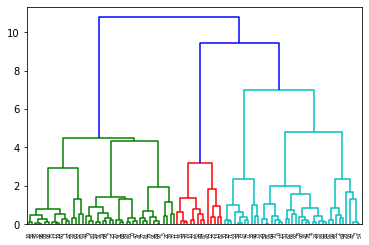

<Figure size 1200x800 with 0 Axes>

In [ ]:
h_cluster = sch.linkage(customers[['CAI','ln_BS_Score']], metric='euclidean', method='ward')
dendogram = sch.dendrogram(h_cluster)
h_cluster = sch.fcluster(h_cluster, 3, criterion='maxclust')
# plt.title('Dendograms')
plt.figure(dpi=200)
dendogram.keys()
plt.show()


In [ ]:
customers['h_cluster'] = h_cluster
# customers.h_cluster.value_counts()

## **K-means**

In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=50, random_state=0)
kmeans.fit(customers[['CAI','ln_BS_Score']])
k_means = kmeans.predict(customers[['CAI','ln_BS_Score']])
customers['k_means'] = k_means
customers.k_means.value_counts()

1    41
0    32
2    26
Name: k_means, dtype: int64

## **Scatter Matrix**

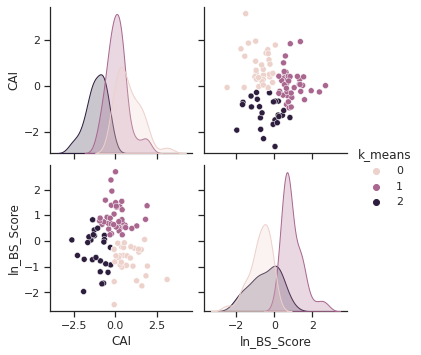

In [ ]:
sns.set_theme(style='ticks')
sns.pairplot(customers[['CAI','ln_BS_Score','k_means']], hue='k_means')
plt.show()

In [ ]:
# plt.scatter(x=customers.CAI, y=customers.ln_BS_Score, c=customers.k_means)

## **Cluster property**

In [ ]:
customers.groupby(by='k_means').mean()[['R','F','M_mean','BS_Score','CAI']]

,R,F,M_mean,BS_Score,CAI
k_means,,,,,
0,100.343750,16.187500,2402.808824,88.495723,0.794920
1,7.878049,157.731707,2251.764124,660.536858,0.111424
2,143.153846,29.923077,2877.874063,142.257687,-1.154071


- 0 發展群
- 1 主力群
- 2 離失群

In [ ]:
def clusterporperty(x):
    if x == 0:
        return '發展群'
    if x == 1:
        return '主力群'
    else:
        return '離失群'

In [ ]:
customers['ClusterName'] = customers.k_means.apply(clusterporperty)

# **Chi-Squared Test**

In [ ]:
df = customers.copy()
df.head(1)

,客戶ID,年齡,生日,居住地,教育程度,性別,婚姻狀況,職業,辦第一張信用卡的時間,R,F,M_mean,BS_Score,M_sum,CAI,CRI,Basket1,Basket2,Basket3,Basket4,Basket5,首次辦卡年齡,年齡層,首辦年齡層,持卡年數,持卡數,曾分期付款,曾國外消費,02_學費/教育,03_保險,05_捐贈,06_公用事業,07_百貨,08_精品,09_餐飲,10_藥妝,11_3C居家電信,12_量販超市,13_交通(含加值),14_旅遊,15_休閒文化,16_無店舖,X2.中信錢加值,月初,月中,月底,週一,週二,週三,週四,週五,週六,週日,最常消費產業,最常消費月時點,最常消費週時點,birthdate,zodiac,zodiac_type,ln_R,ln_F,ln_M,ln_BS_Score,h_cluster,k_means,ClusterName
0,89,59,1953-09-21,大台北地區,學士,1:男,已婚,白領主管,2003-11-27,19,85,1772.717647,369.909059,150681,-0.802598,0.364911,0.17653,-0.81513,-0.05315,-0.00061,0.36438,50,50歲以上,41-50歲,9,2,False,False,0.0,0.0,0.0,0.0,0.199023,0.0,0.092693,0.0,0.0,0.285829,0.361134,0.061322,0.0,0.0,0.0,0.207564,0.503262,0.289174,0.429809,0.121422,0.346334,0.049681,0.052754,0.0,0,13_交通(含加值),月中,週一,1953-09-21,處女座,土象,0.096628,0.663452,0.018199,0.642222,1,1,主力群


## **Location_Test**

In [ ]:
contigency = pd.crosstab(df['居住地'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
居住地,,,
台中地區,0.352941,0.294118,0.352941
嘉南地區,0.333333,0.444444,0.222222
大台北地區,0.442308,0.307692,0.250000
高屏地區,0.428571,0.333333,0.238095


Chi-square is 1.57
p_value is 0.95


## **Education_Test**

In [ ]:
contigency = pd.crosstab(df['教育程度'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
教育程度,,,
其他,0.000000,0.000000,1.000000
初中及初中以下,0.250000,0.500000,0.250000
學士,0.431818,0.250000,0.318182
專科,0.473684,0.368421,0.157895
研究所以上,0.500000,0.416667,0.083333
高中,0.315789,0.368421,0.315789


Chi-square is 8.59
p_value is 0.57


## **Sex_Test**

In [ ]:
contigency = pd.crosstab(df['性別'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
性別,,,
1:男,0.431373,0.352941,0.215686
2:女,0.395833,0.291667,0.312500


Chi-square is 1.25
p_value is 0.54


## **Single_Test**

In [ ]:
contigency = pd.crosstab(df['婚姻狀況'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
婚姻狀況,,,
單身,0.486486,0.270270,0.243243
已婚,0.370968,0.354839,0.274194


Chi-square is 1.34
p_value is 0.51


## **Occupation_Test**

In [ ]:
contigency = pd.crosstab(df['職業'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
職業,,,
一般服務從業人員,0.000000,1.000000,0.000000
公務員,0.400000,0.200000,0.400000
其他,0.000000,0.000000,1.000000
專業(技術)人員,1.000000,0.000000,0.000000
白領一般職員,0.368421,0.342105,0.289474
白領主管,0.500000,0.277778,0.222222
自營事業老闆,0.444444,0.444444,0.111111
自由業,0.333333,0.333333,0.333333
藍領(勞動工作或作業員)一般職員,0.333333,0.333333,0.333333


Chi-square is 18.43
p_value is 0.78


## **Age_Test**

In [ ]:
contigency = pd.crosstab(df['年齡層'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
年齡層,,,
30歲以下,0.333333,0.250000,0.416667
31-40歲,0.611111,0.222222,0.166667
41-50歲,0.480000,0.360000,0.160000
50歲以上,0.318182,0.363636,0.318182


Chi-square is 7.44
p_value is 0.28


## **Fisrt_Age_Test**

In [ ]:
contigency = pd.crosstab(df['首辦年齡層'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
首辦年齡層,,,
30歲以下,0.392857,0.321429,0.285714
31-40歲,0.600000,0.320000,0.080000
41-50歲,0.370370,0.333333,0.296296
50歲以上,0.263158,0.315789,0.421053


Chi-square is 8.46
p_value is 0.21


## **Installment_Test**

In [ ]:
contigency = pd.crosstab(df['曾分期付款'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
曾分期付款,,,
False,0.394737,0.342105,0.263158
True,0.478261,0.260870,0.260870


Chi-square is 0.66
p_value is 0.72


## **Aboard_Test**

In [ ]:
contigency = pd.crosstab(df['曾國外消費'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
曾國外消費,,,
False,0.350649,0.376623,0.272727
True,0.636364,0.136364,0.227273


Chi-square is 6.56
p_value is 0.04


## **Industry_Test**

In [ ]:
contigency = pd.crosstab(df['最常消費產業'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
最常消費產業,,,
02_學費/教育,0.500000,0.500000,0.000000
03_保險,1.000000,0.000000,0.000000
06_公用事業,0.500000,0.500000,0.000000
07_百貨,0.428571,0.357143,0.214286
08_精品,0.000000,0.000000,1.000000
09_餐飲,1.000000,0.000000,0.000000
10_藥妝,0.500000,0.500000,0.000000
11_3C居家電信,0.333333,0.416667,0.250000
12_量販超市,0.280000,0.480000,0.240000


Chi-square is 32.53
p_value is 0.18


## **Month_Test**

In [ ]:
contigency = pd.crosstab(df['最常消費月時點'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
最常消費月時點,,,
月中,0.484848,0.303030,0.212121
月初,0.440000,0.240000,0.320000
月底,0.341463,0.390244,0.268293


Chi-square is 2.75
p_value is 0.60


## **Weekday_Test**

In [ ]:
contigency = pd.crosstab(df['最常消費週時點'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
最常消費週時點,,,
週一,0.500000,0.239130,0.260870
週三,0.500000,0.318182,0.181818
週二,0.294118,0.352941,0.352941
週五,0.000000,0.666667,0.333333
週四,0.250000,0.500000,0.250000


Chi-square is 10.02
p_value is 0.26


In [ ]:
contigency = pd.crosstab(df['最常消費週時點'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
最常消費週時點,,,
週一,0.500000,0.239130,0.260870
週三,0.500000,0.318182,0.181818
週二,0.294118,0.352941,0.352941
週五,0.000000,0.666667,0.333333
週四,0.250000,0.500000,0.250000


Chi-square is 10.02
p_value is 0.26


## **Zodiac_Test**

In [ ]:
contigency = pd.crosstab(df['zodiac_type'], df.ClusterName)
c, p, dof, expected = chi2_contingency(contigency)
display((contigency.T/contigency.sum(axis=1)).T)
print('Chi-square is {:.2f}'.format(c))
print('p_value is {:.2f}'.format(p))

ClusterName,主力群,發展群,離失群
zodiac_type,,,
土象,0.272727,0.363636,0.363636
水象,0.324324,0.405405,0.270270
火象,0.500000,0.166667,0.333333
風象,0.523810,0.380952,0.095238


Chi-square is 8.96
p_value is 0.18


# **F_test**

In [ ]:
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')
df = df.dropna()

def f_test(y_var, x_var):
    sns.boxplot(x=df[y_var], y=df[x_var], orient='h')
    display(df.groupby(x_var).agg({y_var: ['mean', 'std', 'count']}))
    stats, pvalue = f_oneway(*[s for idx, s in df.groupby(x_var)[y_var]])
    print('F statistics is {:.2f}'.format(stats))
    print('Pvalue is {:.2f}'.format(pvalue))
    if pvalue < 0.2 and len(pd.unique(df[x_var])) > 2:
        mc = MultiComparison(df[y_var], df[x_var])
        mc_results = mc.tukeyhsd(alpha=0.2)
        display(mc_results.summary()) 

--2021-06-01 06:31:06--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 108.177.126.101, 108.177.126.100, 108.177.126.138, ...
Connecting to drive.google.com (drive.google.com)|108.177.126.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/934v4je7apuvqkn1o9i96qeuhhha7863/1622529000000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-06-01 06:31:07--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/934v4je7apuvqkn1o9i96qeuhhha7863/1622529000000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.143.132, 2a00:1450:4013:c03::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|74

## **Location_Test**

ln_BS_Score                
             mean       std count
居住地                              
台中地區    -0.097348  0.848177    17
嘉南地區     0.048652  0.761472     9
大台北地區    0.067097  1.013984    52
高屏地區    -0.026569  1.162869    21

F statistics is 0.13
Pvalue is 0.94


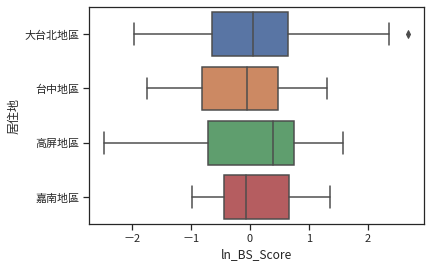

In [ ]:
f_test(y_var='ln_BS_Score', x_var='居住地')

CAI                
           mean       std count
居住地                            
台中地區  -0.125737  0.949420    17
嘉南地區   0.221047  1.068637     9
大台北地區  0.036767  1.012872    52
高屏地區  -0.083989  1.029404    21

F statistics is 0.30
Pvalue is 0.82


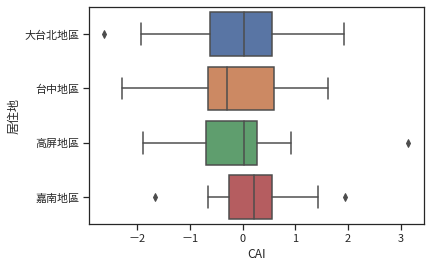

In [ ]:
f_test(y_var='CAI', x_var='居住地')

## **Education_Test**

ln_BS_Score                
               mean       std count
教育程度                               
其他         0.035565       NaN     1
初中及初中以下   -0.317569  0.926425     4
學士        -0.003785  1.005168    44
專科         0.029095  0.860426    19
研究所以上      0.139415  1.070567    12
高中         0.046816  1.140473    19

F statistics is 0.13
Pvalue is 0.99


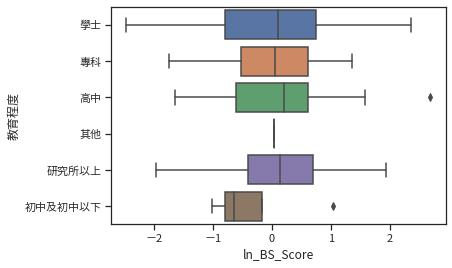

In [ ]:
f_test(y_var='ln_BS_Score', x_var='教育程度')

CAI                
             mean       std count
教育程度                             
其他      -1.472818       NaN     1
初中及初中以下 -0.318362  1.061658     4
學士      -0.231451  0.929332    44
專科       0.454116  0.851109    19
研究所以上    0.097365  0.930007    12
高中       0.164923  1.189022    19

F statistics is 1.99
Pvalue is 0.09


group1,group2,meandiff,p-adj,lower,upper,reject
其他,初中及初中以下,1.1545,0.8955,-1.3666,3.6755,False
其他,學士,1.2414,0.7818,-1.039,3.5217,False
其他,專科,1.9269,0.3952,-0.3865,4.2404,False
其他,研究所以上,1.5702,0.6179,-0.7768,3.9171,False
其他,高中,1.6377,0.5667,-0.6757,3.9512,False
初中及初中以下,學士,0.0869,0.9,-1.0907,1.2645,False
初中及初中以下,專科,0.7725,0.6787,-0.468,2.0129,False
初中及初中以下,研究所以上,0.4157,0.9,-0.8861,1.7176,False
初中及初中以下,高中,0.4833,0.9,-0.7572,1.7237,False
學士,專科,0.6856,0.1181,0.0666,1.3046,True


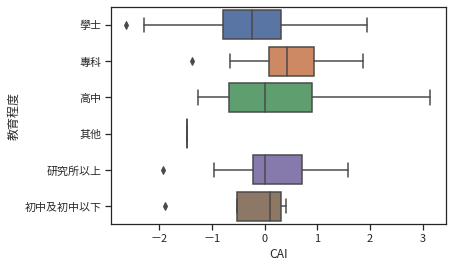

In [ ]:
f_test(y_var='CAI', x_var='教育程度')

## **Sex_Test**

ln_BS_Score                
           mean       std count
性別                             
1:男    0.103527  1.017384    51
2:女   -0.074288  0.962013    48

F statistics is 0.80
Pvalue is 0.37


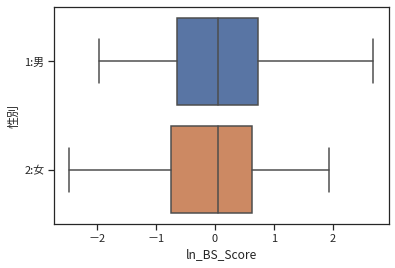

In [ ]:
f_test(y_var='ln_BS_Score', x_var='性別')

CAI                
         mean       std count
性別                           
1:男  0.038391  0.953357    51
2:女 -0.040791  1.055890    48

F statistics is 0.15
Pvalue is 0.70


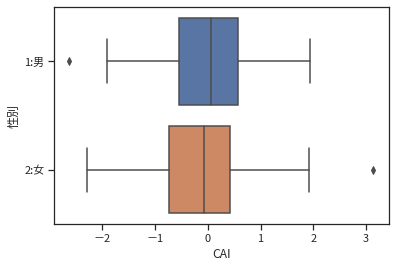

In [ ]:
f_test(y_var='CAI', x_var='性別')

## **Single_Test**

ln_BS_Score                
            mean       std count
婚姻狀況                            
單身      0.116885  0.883476    37
已婚     -0.042108  1.050742    62

F statistics is 0.60
Pvalue is 0.44


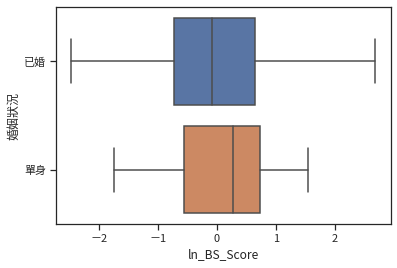

In [ ]:
f_test(y_var='ln_BS_Score', x_var='婚姻狀況')

CAI                
          mean       std count
婚姻狀況                          
單身    0.000298  1.068509    37
已婚   -0.000178  0.965795    62

F statistics is 0.00
Pvalue is 1.00


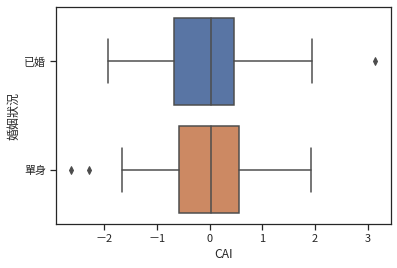

In [ ]:
f_test(y_var='CAI', x_var='婚姻狀況')

## **Occupation_Test**

ln_BS_Score                
                        mean       std count
職業                                          
一般服務從業人員           -0.339486       NaN     1
公務員                 0.036539  0.906199     5
其他                 -0.776925       NaN     1
專業(技術)人員            1.938646       NaN     1
白領一般職員              0.124476  0.741366    38
白領主管               -0.061433  1.051588    18
自營事業老闆             -0.142445  1.225325     9
自由業                -0.296859  1.183844     6
藍領(勞動工作或作業員)一般職員   -0.119173  1.398998     9
藍領(工廠及製造業)主管       -0.042830       NaN     1
軍警                  1.017249  0.411411     3
農漁民                -0.980426       NaN     1
退休或無業              -0.134661  1.301619     6

F statistics is 0.84
Pvalue is 0.60


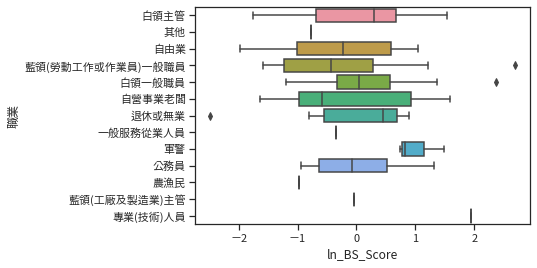

In [ ]:
f_test(y_var='ln_BS_Score', x_var='職業')

CAI                
                      mean       std count
職業                                        
一般服務從業人員          1.574950       NaN     1
公務員              -0.039913  0.730806     5
其他               -0.899008       NaN     1
專業(技術)人員         -0.206490       NaN     1
白領一般職員           -0.075202  1.079446    38
白領主管              0.147361  0.856774    18
自營事業老闆            0.278679  0.960159     9
自由業              -0.246853  1.029732     6
藍領(勞動工作或作業員)一般職員  0.124051  1.470706     9
藍領(工廠及製造業)主管     -0.690421       NaN     1
軍警               -0.678199  0.698438     3
農漁民               1.074199       NaN     1
退休或無業            -0.092891  0.470174     6

F statistics is 0.66
Pvalue is 0.79


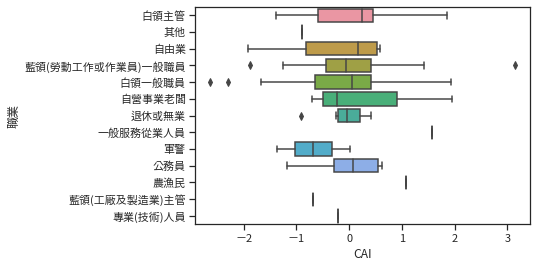

In [ ]:
f_test(y_var='CAI', x_var='職業')

## **Age_Test**

ln_BS_Score                
              mean       std count
年齡層                               
30歲以下     0.204313  0.751552    12
31-40歲    0.363019  0.975288    18
41-50歲    0.154414  1.152899    25
50歲以上    -0.253009  0.908524    44

F statistics is 2.21
Pvalue is 0.09


group1,group2,meandiff,p-adj,lower,upper,reject
30歲以下,31-40歲,0.1587,0.9,-0.5613,0.8788,False
30歲以下,41-50歲,-0.0499,0.9,-0.7284,0.6286,False
30歲以下,50歲以上,-0.4573,0.4759,-1.0865,0.1719,False
31-40歲,41-50歲,-0.2086,0.8953,-0.8059,0.3886,False
31-40歲,50歲以上,-0.616,0.1138,-1.1566,-0.0754,True
41-50歲,50歲以上,-0.4074,0.3437,-0.8913,0.0765,False


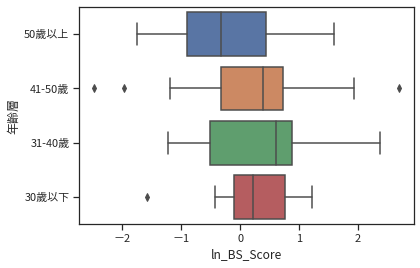

In [ ]:
f_test(y_var='ln_BS_Score', x_var='年齡層')

CAI                
            mean       std count
年齡層                             
30歲以下  -0.494681  1.206312    12
31-40歲  0.030360  0.885813    18
41-50歲  0.199532  0.949907    25
50歲以上   0.009122  1.000532    44

F statistics is 1.33
Pvalue is 0.27


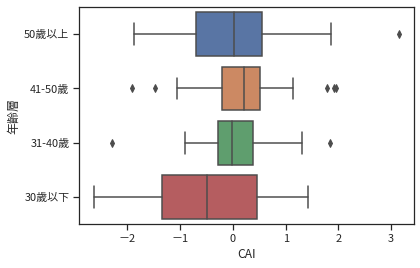

In [ ]:
f_test(y_var='CAI', x_var='年齡層')

## **First_Age_Test**

ln_BS_Score                
              mean       std count
首辦年齡層                             
30歲以下     0.154597  0.824684    28
31-40歲    0.311482  1.155453    25
41-50歲   -0.182962  0.930941    27
50歲以上    -0.287460  0.987591    19

F statistics is 1.94
Pvalue is 0.13


group1,group2,meandiff,p-adj,lower,upper,reject
30歲以下,31-40歲,0.1569,0.9,-0.3769,0.6906,False
30歲以下,41-50歲,-0.3376,0.5677,-0.8608,0.1857,False
30歲以下,50歲以上,-0.4421,0.4289,-1.0186,0.1345,False
31-40歲,41-50歲,-0.4944,0.2681,-1.0328,0.044,False
31-40歲,50歲以上,-0.5989,0.1893,-1.1893,-0.0086,True
41-50歲,50歲以上,-0.1045,0.9,-0.6854,0.4764,False


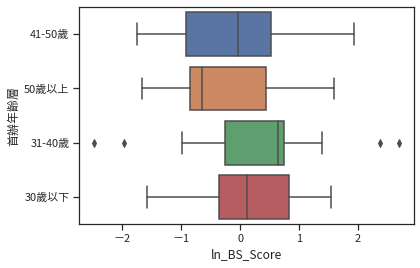

In [ ]:
f_test(y_var='ln_BS_Score', x_var='首辦年齡層')

CAI                
            mean       std count
首辦年齡層                           
30歲以下  -0.170983  1.055884    28
31-40歲  0.278765  0.920613    25
41-50歲 -0.051599  0.825262    27
50歲以上  -0.041496  1.224378    19

F statistics is 0.95
Pvalue is 0.42


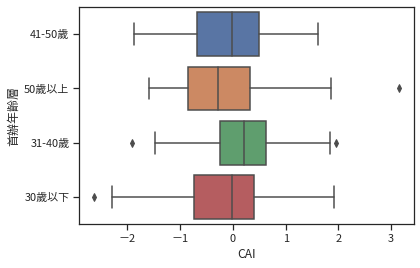

In [ ]:
f_test(y_var='CAI', x_var='首辦年齡層')

## **Installment_Test**

ln_BS_Score                
             mean       std count
曾分期付款                            
False   -0.142941  0.965407    76
True     0.546851  0.897736    23

F statistics is 9.30
Pvalue is 0.00


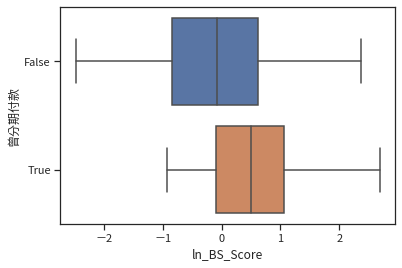

In [ ]:
f_test(y_var='ln_BS_Score', x_var='曾分期付款')

CAI                
           mean       std count
曾分期付款                          
False  0.014217  1.068562    76
True  -0.046978  0.747633    23

F statistics is 0.07
Pvalue is 0.80


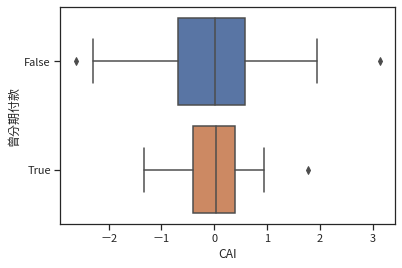

In [ ]:
f_test(y_var='CAI', x_var='曾分期付款')

## **Aboard_Test**

ln_BS_Score                
             mean       std count
曾國外消費                            
False   -0.165510  0.981020    77
True     0.657195  0.733822    22

F statistics is 13.30
Pvalue is 0.00


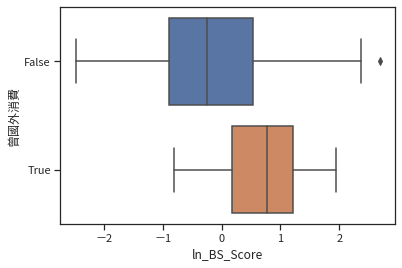

In [ ]:
f_test(y_var='ln_BS_Score', x_var='曾國外消費')

CAI                
           mean       std count
曾國外消費                          
False  0.076161  1.025137    77
True  -0.266563  0.876175    22

F statistics is 2.03
Pvalue is 0.16


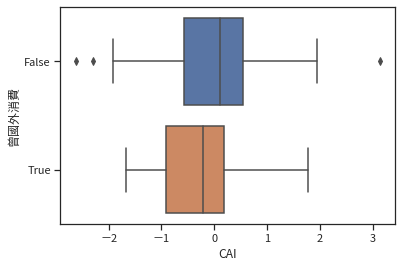

In [ ]:
f_test(y_var='CAI', x_var='曾國外消費')

## **Industry_Test**

ln_BS_Score                
                  mean       std count
最常消費產業                                
02_學費/教育      0.146495  0.129419     2
03_保險         0.936321  0.571021     3
06_公用事業       1.301158  1.963446     2
07_百貨        -0.275433  1.360810    14
08_精品        -1.221931       NaN     1
09_餐飲         1.586477       NaN     1
10_藥妝         0.155343  0.539873     2
11_3C居家電信     0.073755  0.769347    12
12_量販超市      -0.270625  1.011053    25
13_交通(含加值)    0.183903  0.737172    15
14_旅遊         0.234655  0.827787    15
15_休閒文化      -0.554896  1.304812     3
16_無店舖        0.139902  0.254847     3
X2.中信錢加值      0.037753       NaN     1

F statistics is 1.25
Pvalue is 0.26


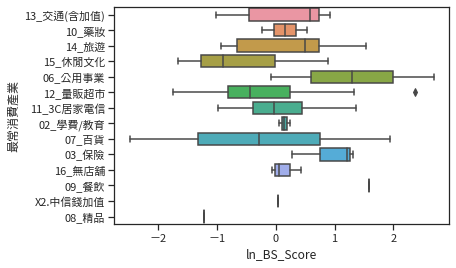

In [ ]:
f_test(y_var='ln_BS_Score', x_var='最常消費產業')

CAI                
                mean       std count
最常消費產業                              
02_學費/教育    0.728810  1.482739     2
03_保險       0.086059  0.323993     3
06_公用事業     0.083557  0.096592     2
07_百貨       0.120446  0.928394    14
08_精品      -0.437831       NaN     1
09_餐飲      -0.596950       NaN     1
10_藥妝       0.653734  0.414323     2
11_3C居家電信   0.141071  0.896499    12
12_量販超市     0.083979  1.162876    25
13_交通(含加值)  0.274137  1.045301    15
14_旅遊      -0.257242  0.828147    15
15_休閒文化    -0.553904  0.235832     3
16_無店舖     -1.199090  0.508537     3
X2.中信錢加值   -2.628617       NaN     1

F statistics is 1.41
Pvalue is 0.17


group1,group2,meandiff,p-adj,lower,upper,reject
02_學費/教育,03_保險,-0.6428,0.9,-3.2178,1.9323,False
02_學費/教育,06_公用事業,-0.6453,0.9,-3.4661,2.1756,False
02_學費/教育,07_百貨,-0.6084,0.9,-2.7407,1.524,False
02_學費/教育,08_精品,-1.1666,0.9,-4.6214,2.2881,False
02_學費/教育,09_餐飲,-1.3258,0.9,-4.7805,2.129,False
02_學費/教育,10_藥妝,-0.0751,0.9,-2.8959,2.7457,False
02_學費/教育,11_3C居家電信,-0.5877,0.9,-2.7422,1.5667,False
02_學費/教育,12_量販超市,-0.6448,0.9,-2.7177,1.428,False
02_學費/教育,13_交通(含加值),-0.4547,0.9,-2.5781,1.6688,False
02_學費/教育,14_旅遊,-0.9861,0.9,-3.1095,1.1374,False


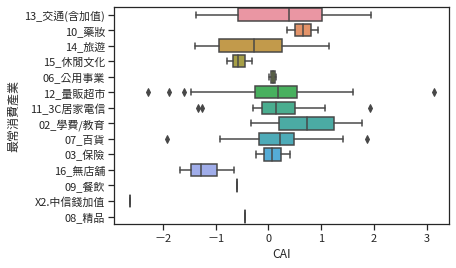

In [ ]:
f_test(y_var='CAI', x_var='最常消費產業')

## **Month_Test**

ln_BS_Score                
               mean       std count
最常消費月時點                            
月中         0.129263  0.898611    33
月初         0.052727  1.153991    25
月底        -0.094386  0.965339    41

F statistics is 0.48
Pvalue is 0.62


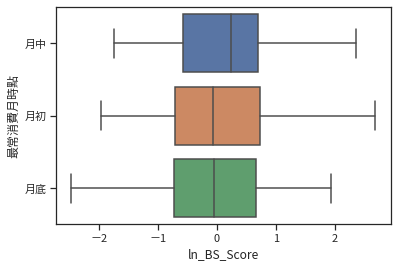

In [ ]:
f_test(y_var='ln_BS_Score', x_var='最常消費月時點')

CAI                
             mean       std count
最常消費月時點                          
月中      -0.088104  0.989597    33
月初      -0.181645  0.821465    25
月底       0.181672  1.095820    41

F statistics is 1.22
Pvalue is 0.30


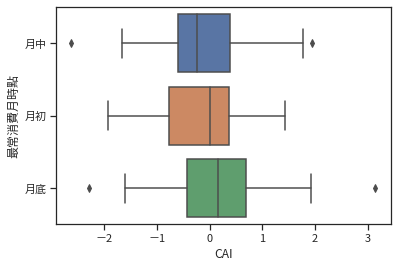

In [ ]:
f_test(y_var='CAI', x_var='最常消費月時點')

## **Weekday_Test**

ln_BS_Score                
               mean       std count
最常消費週時點                            
週一         0.272253  0.981683    46
週三         0.179352  0.825537    22
週二        -0.211267  0.895239    17
週五        -1.475421  0.673299     6
週四        -0.288912  0.818440     8

F statistics is 5.64
Pvalue is 0.00


group1,group2,meandiff,p-adj,lower,upper,reject
週一,週三,-0.0929,0.9,-0.6036,0.4178,False
週一,週二,-0.4835,0.3371,-1.0427,0.0757,False
週一,週五,-1.7477,0.001,-2.6029,-0.8925,True
週一,週四,-0.5612,0.4924,-1.3159,0.1936,False
週三,週二,-0.3906,0.6507,-1.0269,0.2456,False
週三,週五,-1.6548,0.0014,-2.5622,-0.7473,True
週三,週四,-0.4683,0.6973,-1.2817,0.3452,False
週二,週五,-1.2642,0.0335,-2.1997,-0.3286,True
週二,週四,-0.0776,0.9,-0.9224,0.7671,False
週五,週四,1.1865,0.1191,0.1225,2.2506,True


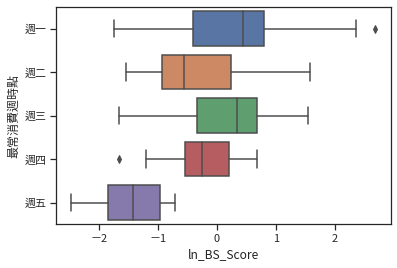

In [ ]:
f_test(y_var='ln_BS_Score', x_var='最常消費週時點')

CAI                
             mean       std count
最常消費週時點                          
週一      -0.123760  0.905055    46
週三       0.206642  0.909456    22
週二      -0.124367  0.940686    17
週五       0.249666  2.015007     6
週四       0.220385  0.974023     8

F statistics is 0.66
Pvalue is 0.62


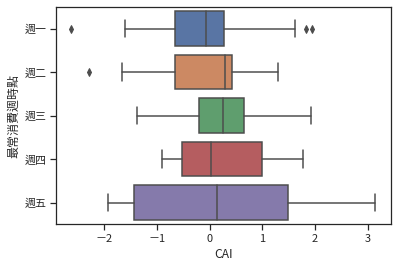

In [ ]:
f_test(y_var='CAI', x_var='最常消費週時點')

## **Zodiac_Test**

ln_BS_Score                
                   mean       std count
zodiac_type                            
土象            -0.218330  1.081172    11
水象            -0.025134  0.930959    37
火象             0.015073  0.883446    30
風象             0.218736  1.203724    21

F statistics is 0.51
Pvalue is 0.67


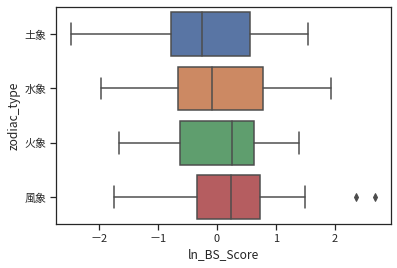

In [ ]:
f_test(y_var='ln_BS_Score', x_var='zodiac_type')

CAI                
                 mean       std count
zodiac_type                          
土象          -0.286358  0.617690    11
水象           0.037117  1.009404    37
火象          -0.239865  1.027720    30
風象           0.427263  1.009000    21

F statistics is 2.25
Pvalue is 0.09


group1,group2,meandiff,p-adj,lower,upper,reject
土象,水象,0.3235,0.7473,-0.3463,0.9933,False
土象,火象,0.0465,0.9,-0.641,0.734,False
土象,風象,0.7136,0.2131,-0.0123,1.4396,False
水象,火象,-0.277,0.642,-0.7562,0.2022,False
水象,風象,0.3901,0.4696,-0.1427,0.923,False
火象,風象,0.6671,0.0862,0.1122,1.2221,True


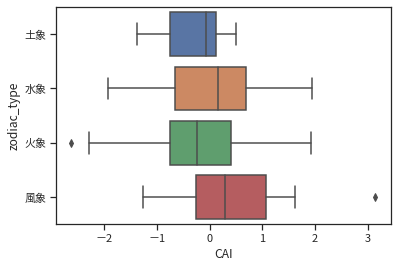

In [ ]:
f_test(y_var='CAI', x_var='zodiac_type')

## **ClusterName_Test**

ln_BS_Score                
                   mean       std count
ClusterName                            
主力群            0.930355  0.544108    41
發展群           -0.754404  0.569884    32
離失群           -0.472676  0.765328    26

F statistics is 78.11
Pvalue is 0.00


group1,group2,meandiff,p-adj,lower,upper,reject
主力群,發展群,-1.6848,0.001,-1.9364,-1.4331,True
主力群,離失群,-1.403,0.001,-1.6704,-1.1356,True
發展群,離失群,0.2817,0.1998,0.0001,0.5634,True


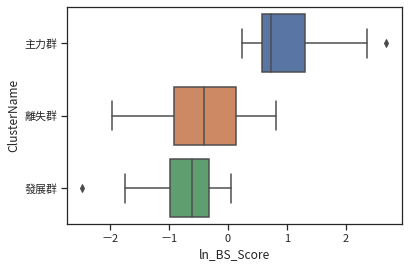

In [ ]:
f_test(y_var='ln_BS_Score', x_var='ClusterName')

CAI                
                 mean       std count
ClusterName                          
主力群          0.111424  0.630947    41
發展群          0.794920  0.757425    32
離失群         -1.154071  0.597765    26

F statistics is 62.32
Pvalue is 0.00


group1,group2,meandiff,p-adj,lower,upper,reject
主力群,發展群,0.6835,0.001,0.4117,0.9553,True
主力群,離失群,-1.2655,0.001,-1.5543,-0.9767,True
發展群,離失群,-1.949,0.001,-2.2532,-1.6448,True


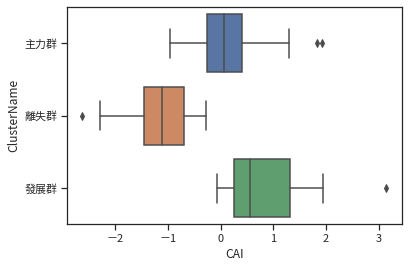

In [ ]:
f_test(y_var='CAI', x_var='ClusterName')

# **Save file**

In [ ]:
customers.to_excel('cluster.xlsx')